In [2]:
import numpy as np
from astropy.io import fits
from zipfile import ZipFile
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
from IPython.display import HTML
import random
import math
import requests
import re

In [4]:
#function for opening fits file and getting header and pixel data
def read_fits_file(target_file):
    tess_file = fits.open(target_file)
    header_data = tess_file[1].header
    check_data = tess_file[1].data
    tess_file.close()
    # Converts flux values to an array.
    pixel_data = np.asarray(check_data)
    return (header_data, pixel_data, check_data)

input_file ='/home/adam/Documents/GammaRayFits/astrocut_7.763_-38.619_20x20px/tess-s0002-2-3_7.763000_-38.619000_20x20_astrocut.fits'
# step 1: read in the data

header, pixels, check = read_fits_file(input_file)

#THe flux values of the GRB frame
GRB_frame = np.stack(pixels['FLUX'][162])
GRB_post_flash = np.stack(pixels['FLUX'][163])
GRB_pre_flash = np.stack(pixels['FLUX'][161])

In [5]:
# Reshape flux values for pixels at GRB frame
GRB_frame_list = GRB_frame.reshape(1,400)
GRB_frame_list.sort()

# Get the faintest 20 pixels
faint_pix = GRB_frame_list[0][0:80]

bkgnd_median = np.median(faint_pix)
bkgnd_std = np.std(faint_pix)
print(bkgnd_median + bkgnd_std)

93.32181


In [6]:
#RA and Dec of current target
RA = 7.763
Dec = -38.619

# Generate random RA and Dec +-1 from the target RA and Dec
rand_RA = round(random.triangular(RA - 1, RA + 1),6)
rand_Dec = round(random.triangular(Dec - 1, Dec + 1),6)

print(rand_RA)
print(rand_Dec)

#Calculate distance of random point to target point
euc_distance = math.sqrt(math.pow((RA-rand_RA),2) + math.pow(Dec-rand_Dec,2))
print(euc_distance)

7.807641
-38.142579
0.47850787676066725


In [7]:
#Get Tesscut fits of the random point generated

rand_ra_str = str(rand_RA)
rand_dec_str = str(rand_Dec)

print('this is the ra and dec: ({0},{1})'.format(rand_ra_str,rand_dec_str))
r = requests.get('https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=%s&dec=%s&y=10&x=10'%(rand_ra_str,rand_dec_str),allow_redirects=True)
r.status_code

tess_cutout = r.content
type(tess_cutout)

this is the ra and dec: (7.807641,-38.142579)


bytes

In [8]:
tess_file = open("tess%s_%s.zip"%(rand_ra_str,rand_dec_str), "wb")
tess_file.write(tess_cutout)

2862994

In [9]:
tess_file.close()

In [10]:
with ZipFile('tess%s_%s.zip'%(rand_ra_str,rand_dec_str), 'r') as zip:
    zip.extractall(path='./Background_Tests')

To automate making the mask, I use the pixel header from the fits file, and get the values for the reference pixels


In [13]:
input_file ='./Background_Tests/tess-s0002-2-3_{0}_{1}_11x10_astrocut.fits'.format(rand_ra_str, rand_dec_str)

header, pixels, check = read_fits_file(input_file)

rand_img = np.stack(pixels['FLUX'][0])
pix_head = str(header)
ref_pix = re.findall("\d.\d{12}", pix_head)
print(ref_pix)
# Reference pixel coordinates. The x and y values are flipped. Also, fits coordinates start at 1, and python starts at 0.
# A subtraction of 1 is needed to convert into python coordinates
ref_pix_y = round(float(ref_pix[0]) - 1)
ref_pix_x = round(float(ref_pix[1]) - 1)

print(ref_pix_y,ref_pix_x)

['6.601951978542', '6.009832645436', '0.004855513552', '0.003226411453', '0.003163415598', '0.004820280516', '6.601951978542', '6.009832645436', '0.004855513552', '0.003226411453', '0.003163415598', '0.004820280516', '6.601951978542', '6.009832645436', '0.004855513552', '0.003226411453', '0.003163415598', '0.004820280516', '6.601951978542', '6.009832645436', '0.004855513552', '0.003226411453', '0.003163415598', '0.004820280516', '6.601951978542', '6.009832645436', '0.004855513552', '0.003226411453', '0.003163415598', '0.004820280516', '0.791999995708', '0.016499996185', '5.280000209808', '5.260000228881', '5.210000038146', '1.980000019073', '0.016499996185', '9.873600006103', '7.627000808715', '7.717500209808', '9.899000167846', '0.019999999552', '1.160000010713', '0.020833333954', '7.395826617080']
6 5


In [14]:
len(pixels['FLUX'])

1245

96.71609


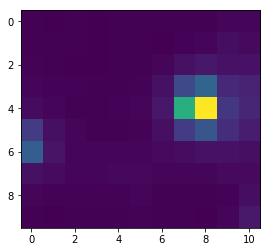

In [15]:
plt.imshow(rand_img)
print(rand_img[ref_pix_y][ref_pix_x])

In [16]:
full_mask_med = []
full_mask_mean = []
temp_mask = []

for cadence in range(1245):
    rand_img = np.stack(pixels['FLUX'][cadence])
    
    center_pix = rand_img[ref_pix_y][ref_pix_x]
    right_pix = rand_img[ref_pix_y - 1][ref_pix_x]
    upper_pix = rand_img[ref_pix_y][ref_pix_x - 1]
    left_pix = rand_img[ref_pix_y - 1][ref_pix_x - 1]
    
    temp_mask.append(center_pix)
    temp_mask.append(right_pix)
    temp_mask.append(upper_pix)
    temp_mask.append(left_pix)
    full_mask_mean.append(np.mean(temp_mask))
    full_mask_med.append(np.median(temp_mask))

if np.mean(full_mask_med) > bkgnd_median + (3 * bkgnd_std):
    print("Fail")
else:
    print("Pass")

Fail


The following code is from the GammaRayBurstsVisualized code.
@author Lindsey Carboneau

In [17]:

'''
# step 1: read in the data
def getFITSdata(tessfile):
    fitsfile = fits.open(tessfile)
    headerdata = fitsfile[0].header
    checkdata = fitsfile[1].data
    fitsfile.close()
    pixeldata = np.asarray(checkdata)
    return (headerdata, pixeldata, checkdata)

header, pixels, check = getFITSdata(inputfile)
'''

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle('Sector 2 GRB', fontsize=20)

ax_im = ax[0]
ax_diff = ax[1]

Z = np.stack(pixels['FLUX'][0])
im_im = ax_im.imshow(Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='PuBu_r', animated=True)
im_diff = ax_diff.imshow(Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='PuBu_r', animated=True)

ax_im.set_title('Raw Flux from FFI - LogNorm')
ax_diff.set_title('Diff Flux: Changes - LogNorm')
ax_im.set_yticklabels([])
ax_im.set_xticklabels([])
ax_diff.set_yticklabels([])
ax_diff.set_xticklabels([])

def updatefig(idx):
    image0 = np.stack(pixels['FLUX'][idx])
    try:
        imageN = np.stack(pixels['FLUX'][idx + 1])
    except IndexError:
        imageN = np.stack(pixels['FLUX'][idx])
    except Exception as ex:
        print('There was a different problem: ' + str(ex))
        
    im_im.set_array(image0)
    
    im_diff.set_array(np.subtract(imageN, image0))
    
    return im_im, 

ani = animation.FuncAnimation(fig, updatefig, frames=len(pixels), blit=True, repeat=True, interval=400)
plt.close(fig)
HTML(ani.to_html5_video())

In [19]:
#Loop for background subtraction of apeture mask.

#List of median values for faintest 20% of pixels. Each index value
#represents one frame.
median_list = []

# List of flux values for every frame, every pixel.
full_frame_list = np.stack(pixels['FLUX'])
# Gets lowest 20% pixels, gets the median of them for each frame and appends to median_list
for frame_num in full_frame_list:
    #List of pixels per frame
    temp_list = frame_num
    temp_list = np.reshape(temp_list, (110))
    temp_list.sort()
    median_list.append(np.median(temp_list[0:10]))

In [23]:
# This function takes a pixel at values x and y, and calculates the mean of the flux value for every frame.
def get_pixel_mean(x, y, pixel_arr):
    temp = []
    # Used to keep track of frame number for background subtraction
    median_frame_count = 0
    for frame in pixel_arr['FLUX']:
        pix_bkg_sub = frame[x][y] - median_list[median_frame_count]
        print(pix_bkg_sub)
        temp.append(pix_bkg_sub)
        median_frame_count+= 1
    return np.mean(temp)

In [26]:
full_img_avg = []
# Loop iterates through a range of 10 since image is 10x10. Change range for larger images.
for x in range(10):
    for y in range(10):
        #Appending the mean over time for this pixel to the full image mean
        full_img_avg.append(get_pixel_mean(x,y,pixels))

0.20691681
0.3756485
-0.024765015
-0.15325165
-0.024490356
0.0087890625
0.16182709
-0.16184998
0.03517914
0.40547943
-0.07707977
-0.011245728
0.19432068
-0.15538025
-0.2817688
-0.03353119
0.48277283
0.32912445
0.22022247
0.2845459
-0.21547699
-0.10838318
0.2994156
-0.1570282
-0.10457611
-0.22570801
0.018928528
-0.004386902
-0.0068740845
0.10535431
0.018554688
0.29929352
0.15755463
0.096092224
-0.09918976
-0.38150024
0.28598785
0.0855484
-0.40261078
-0.08758545
0.14389038
0.50045013
0.4772339
-0.3370514
-0.010482788
0.1942215
-0.13749695
0.3401718
0.05075836
0.71300507
0.20011139
-0.14956665
-0.02470398
-0.1902237
0.2346878
-0.40719604
-0.3062439
0.021972656
0.31797028
0.067871094
-0.17694855
-0.36512756
0.16725922
-0.02872467
0.18386078
0.28720856
0.19871521
0.17076874
-0.32603455
0.31362915
0.0069122314
0.07411194
-0.11668396
-0.014419556
0.09590912
0.52053833
-0.23820496
-0.050819397
-0.16428375
0.26148224
-0.2742691
-0.11338806
0.34264374
0.30921936
-0.19781494
-0.14103699
-0.008705

0.5930481
-0.15487671
0.3072281
0.1472702
-0.020378113
-0.044288635
-0.19218445
0.62122345
-0.1007843
0.35577393
0.33424377
0.02949524
0.46063232
-0.26194763
-0.045814514
0.024475098
-0.20304108
0.67368317
-0.18682098
0.16098022
0.34275818
0.064697266
0.20787811
0.119125366
0.11911011
0.10496521
-0.06465149
0.30591583
0.508934
0.81020355
0.095710754
0.32508087
-0.0005187988
-0.04045868
0.43637085
0.62718964
0.026229858
-0.008132935
-0.00031280518
0.1783371
0.4320755
0.08590698
-0.074401855
-0.027374268
0.33734894
-0.33702087
-0.25827026
0.023704529
0.14964294
0.38909912
0.22885895
-0.2066803
0.18582916
0.15148163
0.18410492
0.1301651
0.27513885
0.034843445
-0.1533432
0.77493286
-0.28853607
-0.033561707
0.23163605
0.65509796
0.71351624
0.21791077
-0.020111084
0.56468964
-0.48255157
-0.0090408325
0.24703217
0.11980438
0.21338654
0.3105774
-0.05695343
-0.10248566
-0.22389984
0.48171997
0.11035156
0.01940155
0.22510529
-0.139534
0.02507019
0.20923615
0.38108826
0.34391785
0.091796875
0.001

0.10409546
0.6728363
0.23085022
1.1118927
0.9157715
0.6270752
0.14689636
0.73265076
0.23101807
0.37434387
0.526886
0.35736084
0.6936493
0.50735474
0.047454834
0.6609802
0.8425598
0.79777527
1.0625
0.7027893
0.40055847
0.37974548
0.54971313
0.3821869
0.100364685
1.1028748
0.9441376
0.2276001
0.62760925
0.51403046
0.34420776
0.24362946
0.30160522
0.26177216
0.05101776
0.63488007
0.04347992
0.26734924
0.48886108
0.3768158
0.04875946
0.29979706
0.34331512
0.55574036
0.3993988
0.019454956
0.36171722
0.25691986
0.41055298
0.68351746
1.3413773
0.37700653
0.5868454
0.8867264
0.39340973
0.16533661
0.56381226
0.5844803
0.15423584
0.8954239
0.16405487
0.7027054
0.5042877
0.8520813
0.5796356
0.6881714
0.40576935
0.5749512
0.77358246
0.5194855
0.6481705
0.49417114
1.0413742
0.35103607
0.4940338
0.61279297
0.88874817
0.35586548
0.018287659
0.49061584
0.96217346
0.45212555
0.22246552
0.46206665
0.69459534
0.37596893
0.49319458
0.25901794
0.23732758
0.9388199
0.5984802
-0.299057
-0.053619385
0.4481811

0.17333221
0.264534
0.50709534
0.62158966
0.60331726
0.6845093
-0.41133118
-0.10626221
-0.2684784
0.2476883
0.31967163
-0.16879272
-0.13706207
0.43092346
0.1502533
0.25956726
0.59436035
0.050559998
0.1894226
0.60180664
-0.030395508
0.2530365
0.53365326
0.2990799
0.124549866
0.05000305
-0.1788559
0.3946228
0.17281342
-0.33104706
0.2748413
0.3536911
0.51116943
0.32952118
0.52378845
0.20978546
0.18414307
0.33026886
0.6569214
0.15127563
-0.057167053
0.14324951
0.022537231
0.021209717
0.14009094
0.5516434
0.7859726
0.18380737
0.41545105
-0.105163574
-0.048065186
0.40374756
0.4049301
0.21050262
-0.11413574
0.49840546
0.06252289
0.1754303
0.011383057
0.19059753
0.01763153
-0.3329773
-0.019325256
0.55519867
0.2696228
0.35182953
0.40717316
0.43624878
0.30137634
-0.094184875
0.5754013
-0.017364502
0.46292114
0.004600525
0.060707092
0.30523682
0.75466156
0.50567627
0.2868805
0.46772766
0.5671692
0.18134308
0.3517456
0.0074920654
0.009216309
-0.10144806
0.59445953
0.4308777
-0.06225586
0.16290283


0.21276855
0.034248352
-0.08770752
-0.10471344
0.49835205
0.053649902
0.2359848
0.09324646
0.5959854
0.12723541
0.51849365
0.2906723
0.4488678
0.3598938
0.5401306
-0.015838623
-0.09680939
-0.030448914
0.24053955
-0.14515686
0.028633118
0.31989288
-0.041389465
0.5659256
0.5092621
0.7248688
0.43636322
0.34681702
0.5623703
0.40249634
-0.23444366
-0.0976944
0.029647827
0.5746002
0.3881073
0.6553421
0.45643616
0.3965149
0.20285034
0.1696167
-0.20796967
0.6634369
0.017356873
0.6281891
0.5930557
0.33128357
0.19381714
0.7552643
0.17092133
0.35025787
0.39038086
0.32126617
0.2503357
0.24595642
-0.12937164
0.28040314
0.14139557
-0.26791382
0.5934448
0.50102234
0.3018875
0.04735565
0.11566162
-0.21707916
0.036506653
0.3781128
0.59532166
0.25398254
0.16518402
-0.020652771
0.4754715
0.31774902
0.27428436
0.7822418
-0.014572144
0.18339539
0.4557495
0.6094742
0.52783203
0.3234787
0.5747452
0.5165787
0.31630707
0.10370636
-0.14585114
0.41610718
0.635231
0.14814758
0.6318283
0.8593216
0.42002106
0.19784

1.6109314
2.0433426
2.0284424
1.7415619
1.8815689
1.85289
1.9791565
1.7754898
1.9677658
1.9160995
1.5651016
1.8423386
2.1246185
1.7571564
1.3620453
1.6694946
1.3731155
2.4053802
1.4502411
1.8015594
1.8991852
1.700737
1.7198105
2.1135788
1.5504227
1.6588058
1.478653
1.4132767
2.0389328
1.4900894
1.9553146
2.0839462
1.4577408
1.6375046
1.6542664
1.8774338
1.5567703
1.7139816
2.0314255
2.1884155
2.6962357
1.5937653
1.7516022
1.6204605
1.9344864
2.3406525
1.9453812
1.8501358
1.794899
1.9661713
1.2888794
1.4393387
2.0347214
1.5074539
2.0235672
1.5405731
1.7774658
1.8313446
1.3287277
1.4313736
1.7634048
2.2914581
1.5005188
1.9105835
1.9880676
1.8840027
1.9633789
1.7187119
1.3843002
1.2999039
1.6605072
2.26091
1.9410172
2.1404037
2.2282104
1.6094971
1.6882935
1.3598251
2.1011505
1.9466019
1.9718246
1.6085129
1.3923264
2.1369095
1.7758331
2.0318375
1.5991211
1.6337357
1.7002716
1.7193909
1.4196243
1.6994934
1.9660568
1.6272736
1.6951294
1.8898926
1.7918472
2.044815
1.3262863
1.3375854
1.661682

0.6556549
1.2515793
0.64443207
0.9386444
0.89429474
1.3019485
0.91134644
1.0804443
0.4107666
0.717453
0.54920197
0.7870407
1.2100067
0.6220169
1.1296387
0.75328827
0.88453674
0.9383774
1.1685257
1.093811
1.1708755
1.0425491
1.2743912
0.727478
1.086525
1.1228638
1.0615005
0.97395325
1.2114944
0.64543915
1.2891617
1.3568115
0.5172119
0.9992676
1.0660324
1.0082779
0.73054504
0.68779755
1.158844
0.92800903
0.26778412
1.132927
0.69997406
1.4508209
0.83114624
1.0237198
0.95669556
1.0540085
1.3244934
0.73566437
0.8338165
0.94179535
0.93164825
1.0175858
0.9103241
0.9272537
0.83943176
0.6683655
0.5718155
0.94620514
0.55579376
0.7667389
1.3588257
0.91013336
0.5999222
0.8436203
0.9152603
0.7559662
1.1545486
0.48755646
0.7725601
0.51942444
0.75795746
0.5845871
0.91368866
1.3176193
0.10644531
1.2156067
0.5311966
0.8108063
1.0834656
0.9252472
0.6299057
0.67987823
0.55981445
0.87031555
0.7654648
1.4057541
0.64273834
1.0025406
0.94757843
0.39344788
1.0438385
0.47618866
0.758461
0.11818695
0.8515701
0.

0.2902069
0.51680756
1.0120773
0.23517609
-0.013824463
0.49334717
-0.30145264
0.3086319
0.16772461
0.11406708
-0.17298889
0.65411377
-0.12600708
0.021575928
0.23400879
0.22793579
0.60149384
0.74503326
0.13400269
0.06427002
0.96949005
0.56604004
0.12750244
0.3258896
0.26965332
-0.013893127
0.41531372
0.9525604
0.50185394
0.20394897
0.5135498
0.7425308
0.21227264
0.29755402
0.10824585
0.051109314
0.33058167
0.0049057007
0.43215942
0.83123016
0.09050751
-0.0054244995
0.3340149
-0.20649719
-0.24944305
0.05181122
-0.0023727417
0.29692078
0.15047455
0.92562866
0.46525574
0.66941833
0.016456604
0.2590866
-0.19441223
0.2690277
0.65786743
0.35533905
0.13465881
0.23958588
-0.3119049
0.23954773
-0.1137619
0.035491943
0.21018219
0.52012634
0.50357056
-0.3826599
0.4555893
0.3297348
0.5798416
0.48565674
0.33581543
0.05064392
-0.034942627
0.15598297
0.12609863
0.13920593
-0.40518188
0.32533264
0.033950806
-0.12953949
0.003112793
0.44883728
0.8573532
-0.22182465
0.44441986
0.013717651
0.18539429
-0.06

9.042572
9.440727
8.930679
9.185875
8.873436
9.128082
9.029251
9.179253
8.433746
9.670006
8.903099
9.252388
9.174355
8.869888
8.942024
8.9513855
8.412521
9.053459
9.022408
9.795586
8.75135
8.4112625
9.027817
9.04361
8.691971
9.730263
9.115593
8.841484
8.978264
9.334602
9.016808
8.508049
9.260345
8.968414
8.51548
9.124199
9.244423
9.085182
9.497032
8.771393
9.312325
9.319641
8.735077
9.209442
9.184921
9.351013
8.918045
9.257545
9.256645
9.632851
8.73954
9.879089
10.360733
12.462021
13.911926
8.849251
8.842743
9.619926
8.796127
9.253769
8.976006
9.139999
8.5112
8.83326
8.724075
8.932587
9.172989
9.198547
9.323433
8.92527
9.160347
9.244209
9.314598
9.173172
8.915222
8.7011795
9.360062
9.399704
8.823669
9.007355
8.93084
8.801743
9.202393
9.637512
9.2547455
8.892372
9.135231
9.0750885
8.916016
9.1651
9.135399
9.498177
9.007454
8.9904785
9.220566
8.71888
9.483673
9.042786
9.073265
9.268463
9.2471695
8.7847595
9.290619
8.948448
9.251038
8.84375
9.177742
9.235252
9.143837
9.2789
8.688393
8.817

0.8565521
0.54345703
1.5057297
0.9438324
0.7355957
1.1174927
0.95175934
0.63972473
0.88246155
0.910553
1.7271347
1.1780777
1.1143417
1.0123978
1.5368423
0.6764374
1.4563751
1.6997147
0.812912
1.2798004
1.068222
1.6388474
1.3914108
0.6624985
1.4317932
1.3991776
1.0378342
1.0973358
1.5952225
1.2654724
0.64385223
1.1432877
1.2318115
0.9627762
1.3933868
0.80818176
0.8684082
0.88373566
1.2978439
1.3453522
0.73807526
1.3200226
1.5550537
1.073143
0.99915314
1.0183411
1.4769974
1.1440659
0.88978577
1.2786636
1.091919
1.1432343
1.3113632
1.1125565
1.1875916
1.094902
1.0216522
1.0382538
1.0371094
0.6804352
0.98680115
1.1444397
0.8800354
0.666008
1.3066254
1.1268387
1.0109558
1.1805954
1.0297394
1.1962357
0.6810379
0.79047394
1.1426163
1.3196487
0.7604675
0.49396515
0.6424713
0.9103775
0.86730194
1.5905838
0.7167969
0.82349396
0.10648346
1.1109009
1.0663834
1.1342087
1.3766632
0.5624008
1.2661972
1.2457123
1.0690842
0.76836395
1.1707764
1.3123856
0.65730286
1.1590271
1.5928116
1.0979538
0.9490738

0.089775085
0.33829498
-0.008460999
0.7571106
0.21642303
0.94927216
0.38851166
0.18736267
0.38777924
0.7454834
-0.079216
0.37002563
0.5094986
0.1329422
0.5350876
0.3368683
0.43457794
0.72663116
0.6234894
0.3136902
0.11733246
0.8220749
0.83086395
0.7546005
0.06651306
0.50523376
0.05480194
0.27587128
0.49507904
0.15301514
-0.07624817
-0.07496643
0.33898163
0.10697174
1.0773697
0.27602386
0.11833954
0.40999603
0.30638123
1.2594452
0.14170837
0.59132385
0.45187378
0.4470749
0.78067017
0.33724213
0.58397675
0.32720947
1.3527832
0.47683716
0.6467056
0.51361084
-0.05379486
0.19391632
0.22432709
0.032958984
0.20200348
-0.06450653
0.18141174
0.012817383
0.20899963
0.22356415
0.031532288
-0.18022156
0.6254654
0.36309052
0.7033081
0.49908447
-0.024627686
0.33971405
0.5632782
0.21143341
0.34029388
0.1206131
0.27298737
0.16176605
0.3478546
0.22538757
0.058044434
0.018585205
0.22653961
-0.17062378
0.33895874
0.347229
0.052947998
0.17998505
0.40527344
0.77471924
0.3043747
0.28897095
0.6510773
0.55113

63.565536
64.09665
64.76213
63.948303
64.65588
64.53238
64.01822
63.85971
63.617874
64.402725
63.936104
64.537384
64.57199
63.831253
64.24234
63.82695
63.91189
63.68805
64.44008
64.3519
64.13806
63.81186
64.178894
64.51191
63.918716
63.679657
64.49341
63.986115
64.06143
64.3311
64.58275
64.647
63.95894
64.36467
64.15729
64.067924
64.78244
64.260956
64.70786
64.299866
64.82127
64.49051
64.55103
64.49238
64.0305
64.79162
64.3709
64.50753
64.00763
64.798584
63.90937
64.09062
64.37509
64.47839
64.33383
64.908646
64.7186
64.32507
64.852615
64.58032
64.18871
65.11705
64.57927
64.925125
64.15758
64.57791
64.09
63.49211
65.11492
65.01932
64.679474
64.35992
64.55798
64.66513
64.70662
64.88483
64.17871
64.71466
64.93001
64.215096
65.104225
65.01402
64.74829
65.17665
63.33152
64.37205
65.199646
64.56702
65.42409
64.64504
64.41878
64.601685
64.52995
64.95586
65.39084
64.664474
65.115036
64.37747
64.388535
64.86421
64.844894
64.60297
64.95915
65.04054
65.21117
64.94377
63.82805
65.20996
64.99187
65

3.2582474
3.1128006
3.4690323
3.1096191
3.0247345
3.0753174
3.3758698
3.1910706
3.5441132
3.2480087
2.8960571
3.0507507
3.6872025
2.9833145
2.9227371
2.9242096
3.3802261
3.0858154
3.3381042
3.3636017
2.922554
3.0445328
3.100319
3.1367035
2.595665
2.8793259
3.1914673
2.8442535
3.0236359
3.1399612
4.096596
2.88723
3.1893616
3.1327057
3.3358078
3.567955
2.596817
3.0330124
2.8723984
3.4278336
3.131096
3.246292
3.0586548
3.086525
3.4811783
3.4258423
3.527794
3.1800003
2.802559
2.9584808
2.4613342
3.837677
3.1949463
2.9836884
2.9170303
3.5412445
2.8727112
3.0419388
3.0047607
3.1491165
2.5436249
3.696663
3.2009888
2.594963
2.5375519
2.9774246
2.7855759
3.236435
3.089302
3.2617035
3.3346024
2.9732666
2.95372
3.3845825
3.1881638
2.9728394
3.4399567
2.5698166
3.3976135
2.8494492
3.301056
3.0695496
3.341362
2.644638
3.1438751
3.2818909
2.9504242
2.7202606
3.076416
3.2885437
2.3247833
2.908966
3.5375519
3.4837341
3.0776367
3.2095032
3.5740967
2.9010468
3.361969
3.3576355
2.9855804
3.483078
3.04769

1.651535
1.240799
1.0552139
2.1687012
2.0431213
1.5629959
1.7236786
1.4272766
1.6889191
1.4512177
1.1354294
1.6460342
0.6775131
1.1219254
0.8564148
1.7173233
1.3757553
1.4370499
1.6993256
1.6518707
1.6177673
1.5602036
1.4898071
1.6130295
1.0758057
1.8324432
1.6037674
1.448494
1.1611938
1.4127655
1.7185135
1.5080643
1.4849014
1.8313599
1.7203522
1.9479294
1.6874924
2.1233673
1.8303833
1.0334854
1.2373581
1.4806061
1.5037918
1.3133545
1.5536041
1.3327103
1.7320251
1.7154236
1.3151321
1.362442
0.87602997
1.7888489
2.1335678
1.5800247
1.7651062
1.8301926
1.6500092
1.5891953
1.7607956
1.6722412
1.4028854
1.4882812
1.5762787
1.5871964
1.4760208
1.617897
1.3982239
1.4098129
1.4810104
1.8327408
2.0049133
1.8750076
1.8657074
1.6243668
0.8075485
1.5621719
1.5454102
1.499466
1.6103897
1.20858
1.6106796
1.390091
1.928482
2.1077805
1.7226868
1.1646347
1.2654266
1.346878
1.7753983
1.7356491
2.2857819
1.61837
1.1628265
1.2126617
1.7264862
1.5741882
1.8311157
1.1278229
1.7661285
2.0055847
1.1475525
0.

168.6121
167.55847
168.96606
167.89702
168.42603
168.02586
168.42993
168.21878
167.45761
167.35573
167.22678
167.88882
168.13644
167.66425
167.4486
167.93333
167.23804
168.16147
167.8854
168.16971
168.0874
167.70215
167.53004
166.37206
165.88106
167.22922
166.2039
167.37721
166.41019
167.52026
166.14539
167.12646
166.08707
167.0216
167.62088
166.6041
167.21904
166.63907
167.55722
166.4594
166.99443
166.74084
166.864
166.66174
166.57703
166.3937
165.18694
167.34164
166.74971
165.6959
167.16814
165.24617
166.90297
167.32858
166.73256
165.14833
166.88657
166.13667
166.25064
165.97272
166.12027
167.26346
166.36517
166.10187
165.69453
166.47723
165.80406
166.20123
166.19174
166.23093
168.24942
165.71072
166.19
166.8619
166.51508
166.24733
165.77359
167.171
167.3943
166.63618
165.51266
167.50461
166.97964
166.49295
167.32011
167.35959
166.74742
167.6146
167.13011
167.12698
166.35048
167.61432
166.31139
166.04779
166.20724
139.89047
153.53458
167.96994
169.04324
167.99461
167.95801
167.22153


2.041687
1.4566803
1.8637924
2.101944
2.4661255
2.225914
2.669075
2.5281448
1.6826477
1.8058548
2.418007
1.5781403
2.2771301
2.083458
1.657692
1.6830139
2.1415176
2.3432236
2.4070358
1.6345749
2.3171997
1.822403
2.6627426
2.0803146
1.5762024
2.1140976
1.5602341
2.0259628
2.0173187
2.039154
2.0213318
2.5048752
2.1005402
1.8475647
2.2290115
2.3436584
2.1120834
2.2109756
2.4994202
2.6197052
2.4738312
1.8312378
1.6495743
2.3267288
2.2279358
2.224083
2.1782837
1.9998474
2.017105
2.0259323
1.8631821
2.5563354
2.0934525
2.0221329
1.9757919
2.164627
2.4667816
1.8269119
1.7612381
2.6014252
2.2610855
2.1678772
1.8766937
2.385254
2.2984695
1.8974304
1.7003784
2.0008545
1.9654999
2.1230392
2.2996597
2.436966
1.9276276
2.1714249
2.195732
1.5441284
2.1006012
2.3061905
1.9283981
1.9846725
0.9685364
1.7964859
2.013649
2.3966522
1.6273422
1.8298416
1.9897461
2.0982437
2.081009
1.8289948
2.0072708
2.3998032
2.108345
3.639305
2.2817307
2.1268768
2.1061325
2.0727463
2.3942642
2.2795029
2.4741745
2.4516983

1.8179169
1.9318619
1.502945
1.7228546
1.346672
1.9468689
1.5811234
1.4234848
1.5537491
1.2210312
1.9145508
1.8291016
1.778389
0.90839386
1.8151093
1.757019
1.7776108
1.4414062
1.4901352
1.7142029
2.2747421
1.8345413
1.6526031
1.3423309
1.5496292
1.1380234
1.7547073
1.6115112
1.251503
2.0631866
2.1847076
1.444664
1.6579971
1.6755829
2.0729141
1.3232651
1.6259689
1.7415924
1.5854034
2.1603928
1.8481903
1.7703323
1.5535736
1.7031555
1.2268448
1.7584457
1.5177994
2.1170197
1.9496536
1.7095947
1.9948578
1.7695694
1.6855164
1.730957
2.0505524
1.3115921
1.7667694
1.9500885
1.9124832
1.7858963
2.3237457
1.6535721
1.5310135
1.3682632
1.8924408
1.8798676
1.8092499
1.9613113
1.6931763
1.8405533
1.7213287
1.6502838
2.392868
1.6979675
1.713562
1.7973862
0.9299545
1.7954788
1.5726776
1.7283859
0.7210617
1.3482437
1.4363403
1.9339218
1.9296494
1.638092
1.7242279
1.7716751
1.7743454
1.4677124
2.0606003
1.8324814
1.4015808
1.8935547
1.4203491
1.2858124
1.5721588
1.6879349
2.4514084
1.057991
1.9001465


21.063004
21.028069
21.352806
20.922745
21.852974
21.111595
21.543762
21.427444
21.411995
21.338219
21.507385
20.698479
21.11293
21.227737
20.618706
21.612404
20.432304
21.124146
21.864166
20.80568
21.004204
21.362572
20.720085
21.329681
21.140831
20.983772
21.155945
20.770897
21.716896
21.03415
21.254822
20.676544
20.603287
21.489578
20.984222
21.651611
21.01902
21.311089
21.117744
20.752571
22.68142
21.104996
21.424904
20.394691
20.677368
21.399338
20.882683
20.708267
20.634216
20.867485
21.151672
20.566193
20.928833
20.98513
21.310951
20.804672
21.244164
20.554321
21.030792
21.09465
20.71856
20.714897
20.318092
20.84188
21.321487
20.939743
21.510727
20.439293
21.400154
21.104988
21.696007
21.006134
21.117432
20.971619
21.031487
21.301056
20.855316
20.887535
21.217613
20.9934
20.526512
20.9813
20.676483
20.695114
20.926834
20.797394
20.592941
20.422867
20.77629
20.127983
19.925903
20.954803
21.28505
20.636421
21.264969
21.030228
20.450706
20.235039
21.04007
20.40892
20.612503
20.7401

2.4884415
2.7924957
2.187561
2.0594559
3.1135483
2.850708
2.4152756
2.7251205
2.2683182
2.7820358
2.5164337
2.9271545
2.9792938
2.6013641
2.6523743
2.4531708
2.4844055
3.1495972
2.445732
3.0660248
2.5795593
2.0989761
2.2544327
2.6825333
2.4428635
2.7184448
2.564865
3.0860443
2.7737198
2.9315414
2.8031464
2.8853836
2.6681824
3.3827286
2.392662
2.8321533
2.871849
2.7657013
2.223175
2.5173416
2.9378815
2.7137985
2.7629166
3.4733658
2.7972183
2.3524017
2.3934555
2.745575
2.312439
3.011818
2.4083405
2.370407
2.7452774
2.0653458
2.6786652
2.8913422
2.8161545
2.619522
3.0727234
2.5857239
2.632248
2.863922
2.8000107
2.875702
2.5001297
2.7014236
2.697281
2.7187881
2.5647736
2.5845413
2.3038635
2.7664185
2.3669891
3.0271454
2.704132
2.2422333
2.6619644
2.1022797
2.8470383
2.6727905
2.3195572
2.5362778
2.6008606
2.7880783
2.4756317
2.4281921
2.961708
2.6501694
2.652008
2.132019
2.9112778
2.4274292
2.577736
2.787819
2.4320984
2.3829117
2.2731628
2.7421036
2.3477707
2.87191
2.7299194
2.5024567
2.64

4.0370483
3.9469986
3.6092453
4.6144867
4.466522
3.6320343
3.9586182
3.9607544
4.276024
3.7474594
3.8703156
4.257324
4.050865
4.165695
3.8443985
4.0657654
3.924263
4.508705
4.040161
3.2417297
3.5371933
3.987877
4.2891617
4.6843414
3.6617203
3.9341812
4.060066
3.9830933
4.08609
4.215744
3.8329544
3.6701813
4.4739685
3.6783066
3.9986343
3.6604614
3.711998
4.180023
3.8778915
3.665001
3.5972366
3.6770706
4.304756
3.4610214
3.6217575
3.7502136
3.9540024
4.0994797
3.8527756
3.8207169
3.906517
3.7294083
3.929573
4.2819366
3.7297058
3.8470383
4.0060577
4.389023
3.7516708
3.5802765
4.1099777
3.6944962
3.8455124
3.8134613
4.3107605
4.1227417
3.180275
3.772972
3.6734467
3.4099655
4.1330566
4.542488
4.0032578
4.0833435
3.8759995
4.244568
3.8312607
3.562294
3.6243439
3.5359497
4.359543
3.9209366
4.27977
3.8376923
4.409439
4.248291
3.9121246
3.893837
4.388794
3.4308624
3.6562195
3.8157654
3.9211807
3.8990936
4.5035095
3.6345673
3.6092072
4.1380005
3.994873
3.982048
4.5094376
4.2804565
3.8915253
3.94

8.069229
7.1329803
7.5056
6.9512177
7.5424347
7.088852
7.942688
7.791519
8.324722
7.6241913
7.5316772
7.610718
8.14801
7.3428955
8.1688385
7.913086
7.87059
8.049744
7.9069977
8.922897
7.844986
7.7063293
7.7447205
7.5575104
7.2795715
7.355591
7.293091
8.046997
8.397751
7.8074646
7.92894
6.801239
7.331909
7.0793457
8.056213
7.962204
7.534622
7.6006546
7.6016464
7.777939
8.463829
7.6542053
7.325424
8.257782
7.9503937
7.3679733
8.015259
8.161461
8.105423
8.14901
7.2496185
7.5410614
7.620186
8.303299
7.703911
7.126602
7.441017
7.247635
7.613144
8.151566
7.9180145
7.870041
7.060608
7.5767593
7.39431
7.5660324
7.12162
7.436943
7.327591
7.814842
7.0214844
6.734581
7.3938217
7.060318
7.3372955
7.342659
7.25943
7.3389587
6.9598618
7.7656784
7.5212097
7.5241394
7.4235153
6.7960052
7.0828705
7.3546906
7.042671
7.10157
7.0156403
7.4904785
7.1882553
7.037445
6.829056
7.2401657
7.333809
6.8371735
7.155449
7.310852
7.2790985
7.304451
6.5771866
7.6420364
6.9769745
7.1105804
6.800888
7.4134827
7.534981


2.7073898
2.6856537
3.2305603
2.5006485
2.6916351
2.8024368
2.9052124
2.4744415
2.9800873
2.4288635
3.3398514
3.4197388
2.5743103
3.2589111
3.1845093
3.0327377
3.515686
2.7600555
2.4299698
2.2930908
2.8642273
2.1805954
2.9099808
2.7046432
2.3562698
3.1643448
2.9840546
3.0732193
2.4578476
3.09449
2.8895035
2.7421265
2.866211
2.8923874
3.0053787
2.858406
2.7478943
2.9558868
3.151741
2.5109558
3.0743408
3.0324783
3.1083984
2.8171158
3.176361
3.025093
2.530777
2.829132
2.5517426
2.3700714
2.6427612
2.933403
2.658821
2.5407639
3.4438553
2.583992
2.507286
2.928688
3.0776596
2.8508453
3.0092087
3.2076187
2.6572495
2.9083405
3.0802612
2.3803024
2.9108124
2.5234222
2.8265686
2.9169617
3.2753067
2.814499
2.981865
2.5809708
2.3189926
2.9180908
2.0073395
3.5605774
2.8991776
3.4107208
2.579567
2.847107
2.6666107
2.8117065
2.8582993
2.744049
2.649063
2.594986
2.883522
2.3451385
2.9706955
2.151741
2.386238
2.6597672
2.8662033
2.7045288
2.9048996
2.5985107
2.5506516
2.2723694
2.2977982
2.6101685
2.371

1.6647568
1.7690811
1.6027374
1.7156143
1.7706757
1.7279739
1.5113068
1.4444733
1.9259262
1.7170334
1.2884827
1.6003418
2.134018
1.3112411
1.7814407
1.776413
1.1808472
1.0195923
1.7815628
1.6631927
1.6110916
1.6697235
1.6928177
2.2067642
1.7808609
2.5044556
1.7949219
1.7762833
1.7514801
2.1836014
1.955307
2.0662766
1.5400314
1.8712616
1.8800125
1.7967072
1.9446411
1.6378021
1.7681885
1.5209427
1.7179794
1.4661942
1.5945892
1.6461868
1.9835739
1.2980576
1.2352295
1.5592041
2.2442017
2.126686
1.7910309
1.8497391
1.6999512
1.8107758
1.5828705
1.8213196
1.8466644
1.5296173
1.440773
2.2461853
1.8073349
1.6800079
2.176445
1.6798325
1.3004532
2.0170517
1.0413055
1.3457642
1.7426987
1.8840942
1.604332
2.054634
2.2743149
1.6651382
1.6667709
2.1016846
1.9720001
1.9069519
1.9870758
1.9437637
1.9503021
1.8360672
1.4470673
1.4654694
1.9404068
1.5868683
1.5547562
2.298935
1.7852173
1.4445038
1.7866364
1.4859467
1.8799744
1.5288925
1.5047531
1.8353806
1.5825348
1.5800095
1.3362961
1.5671997
1.9902573

2.0165482
2.0907593
1.2798691
1.8691177
1.8105698
1.7555008
1.9211273
1.3065872
1.0946121
1.9942627
1.8732758
2.0736084
1.530632
1.9695129
1.8446121
1.9269638
1.274353
1.8902359
2.5622025
2.0744019
1.7533951
2.119133
1.837883
1.7685394
2.016388
1.7541962
1.9749832
1.7153778
1.8691788
1.5875702
1.7467957
1.5564194
2.2569656
2.291771
1.7754364
1.7477341
1.3464813
1.7983704
1.4570236
1.7362518
2.1564178
2.1505737
1.5018463
1.1974564
1.8967667
1.8389511
1.4134521
1.64254
1.7457504
1.7136612
2.0345917
1.5591888
1.6892471
1.8292389
2.3413544
1.8205338
2.1690216
1.8276291
1.527214
1.5063934
1.343071
1.9125671
1.6811829
1.7870255
1.6367416
2.2425308
1.6899567
1.5594864
1.1996155
2.0322113
1.9299545
2.1263885
1.6318588
1.4526367
1.7268143
1.4365845
2.1888504
1.4405289
1.4525223
1.1065903
2.034752
1.3062744
2.5671692
1.6714554
1.8185959
1.5529022
1.5883865
1.656044
1.6852417
2.0731277
2.2170181
2.0297012
1.4888763
1.6905136
1.9372253
1.9214706
2.1889954
2.199051
2.105217
1.3470612
1.7252121
2.00

0.692955
1.2321701
0.4346466
0.8626938
0.68367004
0.8505554
0.8297119
0.632782
0.8633957
0.9551239
0.8369522
1.4496994
0.84458923
0.6724167
0.36499786
0.49771118
1.1404114
1.1693802
1.0035706
1.1287537
0.5663376
0.49533844
1.2565765
1.1276321
0.64979553
0.8144989
0.7813721
1.2130051
1.1404495
1.2335892
1.4532089
0.3247223
0.96025085
0.8178787
0.68257904
0.50315857
1.0618057
0.50276184
0.8871002
0.6772461
0.7264252
0.83514404
0.5719223
0.90519714
0.48230743
0.7269745
1.2993469
0.7281952
0.94763947
1.3625412
0.8581772
0.7359009
0.46701813
1.4875336
0.98218536
0.85279846
0.48345947
0.7685852
0.91646576
1.0476685
1.0443115
0.26513672
0.61813354
0.7062607
0.85128784
0.09466553
0.9821472
0.41775513
1.550354
0.85059357
0.5499954
0.72488403
1.2108612
1.0749283
1.0539169
0.63629913
0.980011
0.81526184
0.59454346
1.0537567
0.496109
0.6874695
0.5046463
0.7937546
0.789711
0.76474
1.1725159
0.20063782
1.3064346
1.1766052
1.1657104
1.3065567
0.33221436
0.72036743
1.4417801
0.888031
0.75801086
0.3083

0.7142792
0.3373947
0.36327362
0.5363617
0.60678864
0.7262573
0.6207733
0.30223846
0.37475586
0.96424866
0.64315796
0.8141022
0.53939056
-0.012794495
0.627594
0.6608963
0.50653076
0.5849533
1.0610199
0.74009705
0.36972046
0.57650757
0.53889465
0.42372894
0.79828644
0.7850647
0.2441101
0.56333923
0.49741364
0.8383484
1.1195526
0.5153961
1.1527328
0.77311707
0.37178802
0.55913544
0.6003113
0.404953
0.93920135
0.5809326
0.8876343
1.0212173
0.21533966
0.40179443
0.11904144
0.5479584
0.23078918
0.858902
0.48506165
0.6488495
0.15660095
1.3274536
0.2952652
0.23455048
0.26913452
0.37747192
0.2410965
0.5020447
0.46764374
0.61579895
0.89777374
0.16890717
0.8013077
0.381752
0.09832764
0.31913757
0.34553528
0.37682343
0.6057358
-0.0024032593
0.19482422
0.50009155
0.79626465
0.34423065
0.44207
0.76924896
0.48332214
0.11452484
1.2379379
0.17560577
0.20165253
0.7620621
0.6286316
0.46432495
0.2597885
0.39897156
0.7458954
0.5285187
0.7657623
0.25802612
0.12239075
0.33770752
0.5557251
0.5501785
0.020057

0.4127426
0.14279175
0.43270874
0.44508362
0.46691895
0.43509674
0.4265976
0.34544373
0.08657837
0.18819427
0.0009841919
0.64889526
-0.00077056885
0.4268875
0.045898438
0.31599426
0.4289856
0.90543365
0.7867203
0.2192154
0.6062622
0.53486633
0.4854126
-0.029571533
0.69711304
0.47532654
0.56804657
0.5128174
0.27311707
0.6201477
0.026779175
0.71367645
0.323349
1.1316757
1.0881729
0.6693497
0.67938995
0.2908554
0.5851288
0.6129837
0.25302887
0.30584717
0.37968445
0.55332184
0.17566681
0.58958435
-0.046218872
0.49806976
0.6231384
0.30880737
-0.007659912
0.4320526
0.60504913
0.17990112
0.18701172
0.57102966
0.4986267
0.54016113
0.337471
1.2592316
0.41854095
0.13941193
0.48781586
0.2501526
0.3336258
0.29660034
0.1560669
0.34723663
0.19142151
0.58123016
0.044769287
0.46416473
0.23852539
0.10147095
1.162056
0.7283859
0.5367203
0.5994644
0.6337967
0.36712646
0.52726746
0.19831085
0.16342926
1.0903931
0.016220093
0.8197861
-0.084617615
0.5111847
0.20354462
0.72704315
0.35658264
0.35216522
0.5121

0.8604584
0.49856567
0.74609375
1.133995
0.46466827
1.1484833
0.6195755
0.6854706
0.79602814
0.8549652
0.50216675
1.3767471
1.4526749
0.6693878
0.94384766
0.7338104
0.92554474
1.1036682
0.8781891
0.7808304
0.60028076
0.7902603
0.9375992
0.93505096
0.7078552
1.1517181
1.0012589
1.248558
1.0044022
0.4371872
0.6115875
1.27285
1.2276077
1.1873322
0.54442596
0.5709686
0.8753128
0.9299927
0.9938431
1.3042603
0.3602829
1.2169418
1.3046875
1.0363922
1.3229141
0.55714417
1.0730972
0.8671341
0.53388214
0.6976242
0.6819382
1.1261368
0.97380066
0.94602966
0.44207
0.78383636
1.1187057
0.6930008
0.96572876
0.42208862
1.0976562
0.7160263
0.35118103
0.34442902
0.72867584
0.8238983
0.8584442
1.0282898
1.1164322
0.53881836
1.1039505
0.42472076
0.92723083
0.72402954
1.0414505
0.95783997
0.78276825
0.8749771
0.71564484
0.6945572
1.1424332
1.2118073
1.335144
0.926239
1.255806
0.673851
1.004242
0.7896576
1.6291122
0.56648254
1.1248245
0.86894226
0.51712036
0.6556015
1.2251282
1.2878494
0.5841141
1.0949326
1

-0.39663696
-0.37522125
0.13497925
-0.4271469
-0.269516
0.41069794
0.10243988
0.18881989
0.32946777
0.16132355
0.38199615
-0.034873962
0.39984894
0.016220093
0.06259918
-0.16183472
0.33667755
0.13329315
-0.25590515
0.31153107
-0.0289917
-0.03238678
0.0834198
0.12709808
-0.07408905
-0.14478302
0.7492523
0.10419464
0.0043411255
-0.38868713
0.24964905
0.46913147
0.11117554
-0.04473877
0.1303482
0.12258911
0.341774
0.7986145
-0.01702118
0.16129303
0.2584381
-0.30620575
0.14608002
-0.056640625
0.029670715
0.24417114
-0.08420563
-0.14099884
-0.09133911
0.97522736
0.14489746
0.10630798
-0.13708496
-0.04386902
0.0041503906
-0.038528442
0.018692017
0.6835785
-0.007369995
-0.12802887
-0.08554077
-0.078689575
-0.18112183
0.19425964
-0.43184662
-0.5238037
-0.39685822
-0.568779
0.55003357
0.06750488
0.0023040771
0.07215881
0.39839935
0.3665619
-0.41487122
-0.034309387
-0.05115509
0.022850037
0.15743256
0.18234253
0.015136719
0.082603455
0.025817871
-0.25447083
0.28679657
0.44701385
0.038139343
0.13